In [2]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [4]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


In [1]:
content_path

NameError: ignored

In [5]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img) # bytes
  img = tf.image.decode_image(img, channels=3) # shape(~,~,3) # uint8
  img = tf.image.convert_image_dtype(img, tf.float32) # from 0~255 to 0~1 

  shape = tf.cast(tf.shape(img)[:-1], tf.float32) # (height, width)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32) # new (height, width)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :] # (1, ~, ~, 3)
  return img

In [6]:
def imshow(image, title=None):
  if len(image.shape) > 3: # rank 4
    image = tf.squeeze(image, axis=0) # rank 3

  plt.imshow(image)
  if title:
    plt.title(title)

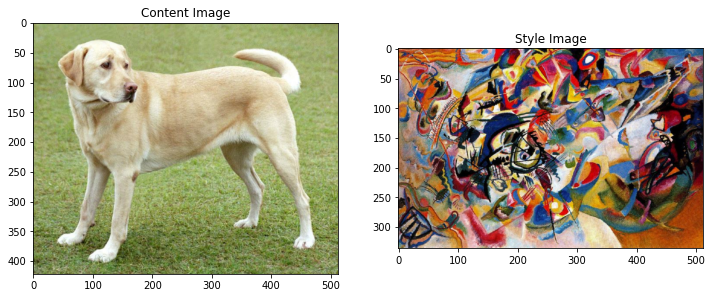

In [7]:
content_image = load_img(content_path) # (1, ~, ~, 3), 0~1
style_image = load_img(style_path) # (1, ~, ~, 3), 0~1

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [8]:
def tensor_to_image(tensor):
  tensor = tensor*255 # from 0~1 to 0~255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor) # image, not array

In [27]:
# import tensorflow_hub as hub
# hub_model = hub.load('https://hub.tensorflow.google.cn/google/magenta/arbitrary-image-stylization-v1-256/2')
# stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
# tensor_to_image(stylized_image)

In [ ]:
# x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
# x = tf.image.resize(x, (224, 224))
# vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
# prediction_probabilities = vgg(x)
# print(prediction_probabilities.shape)

# predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
# [(class_name, prob) for (number, class_name, prob) in predicted_top_5]

In [ ]:
# vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# print()
# for layer in vgg.layers:
#   print(layer.name)

In [9]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [10]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs) # broadcasting ??
  return model

In [ ]:
# style_extractor = vgg_layers(style_layers) # get model
# style_outputs = style_extractor(style_image*255) # it is model # input is numpy

# #Look at the statistics of each layer's output
# for name, output in zip(style_layers, style_outputs):
#   print(name)
#   print("  shape: ", output.numpy().shape)
#   print("  min: ", output.numpy().min())
#   print("  max: ", output.numpy().max())
#   print("  mean: ", output.numpy().mean())
#   print()

In [11]:
def gram_matrix(input_tensor): # (1, height, width, ch)
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) # (1, height*width, ch) X (1, ch, height*width) # (1, ch, ch)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32) # height*width
  return result/(num_locations)

In [12]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers): # Two layer_name_list
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers) # Model(~, ~)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers) # 5
    self.vgg.trainable = False

  def __call__(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs) # input_Tensor, didn't assign in Tensor..?
    outputs = self.vgg(preprocessed_input) # y in 'y=f(x)', 'f' is Model
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs] # (5, 1, ch, ch)?

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict} # {c: {}, s: {}}

In [13]:
extractor = StyleContentModel(style_layers, content_layers)

# results = extractor(tf.constant(content_image))

# print('Styles:')
# for name, output in sorted(results['style'].items()):
#   print("  ", name)
#   print("    shape: ", output.numpy().shape)
#   print("    min: ", output.numpy().min())
#   print("    max: ", output.numpy().max())
#   print("    mean: ", output.numpy().mean())
#   print()

# print("Contents:")
# for name, output in sorted(results['content'].items()):
#   print("  ", name)
#   print("    shape: ", output.numpy().shape)
#   print("    min: ", output.numpy().min())
#   print("    max: ", output.numpy().max())
#   print("    mean: ", output.numpy().mean())

80142336/80134624 [==============================] - 0s 0us/step


In [14]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
print(style_targets.keys())
print(content_targets.keys())
print(style_targets['block1_conv1'].shape) # TensorShape([1, 64, 64])

dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])
dict_keys(['block5_conv2'])
(1, 64, 64)


In [15]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [16]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1 )

In [17]:
style_weight=1e-2
content_weight=1e4
total_variation_weight=30

In [18]:
def style_content_loss(outputs): # maybe extractor(initial_image))
  global style_targets, content_targets
  style_outputs = outputs['style'] # finally dict # {name : Tensor}
  content_outputs = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) # outputs approaches target.
                          for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers

  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                            for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers
  loss = style_loss + content_loss
  return loss

In [ ]:
# def high_pass_x_y(image):
#   x_var = image[:,:,1:,:] - image[:,:,:-1,:] # TensorShape(1, 422, 510, 3) #
#   y_var = image[:,1:,:,:] - image[:,:-1,:,:] # TensorShape(1, 420, 512, 3)

#   return x_var, y_var

In [ ]:
# def total_variation_loss(image):
#   x_deltas, y_deltas = high_pass_x_y(image)
#   return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [19]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image) # in or out

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [20]:
image = tf.Variable(content_image) # 0~1, TensorShape([1, 422, 512, 3])

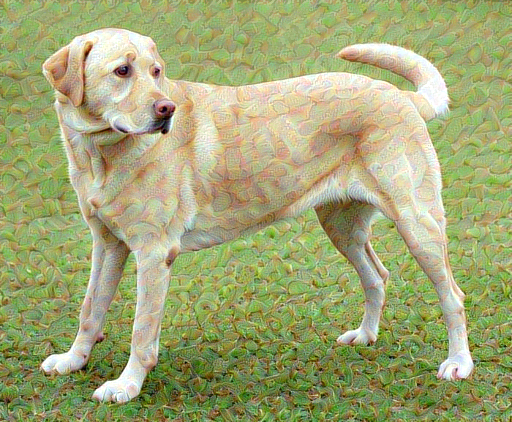

In [21]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

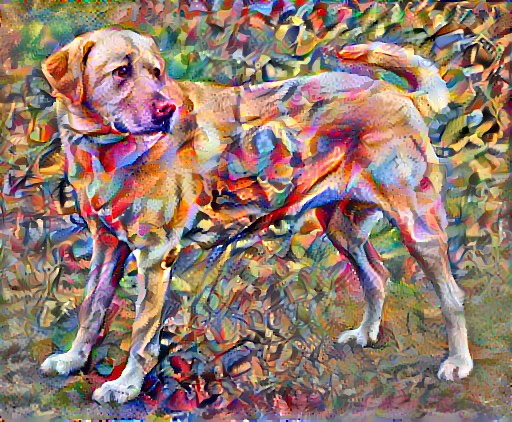

Train step: 1000
Total time: 76.1


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>